In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from sklearn.tree import DecisionTreeRegressor

# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733441 entries, 0 to 733440
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   start_date               733441 non-null  object 
 1   end_date                 733441 non-null  object 
 2   start_time_hourly        733441 non-null  int64  
 3   end_time_hourly          733441 non-null  int64  
 4   start_station_id         733441 non-null  int64  
 5   end_station_id           733441 non-null  int64  
 6   start_latitude           733441 non-null  float64
 7   start_longitude          733441 non-null  float64
 8   end_latitude             733441 non-null  float64
 9   end_longitude            733441 non-null  float64
 10  min_temp                 733441 non-null  float64
 11  max_temp                 733441 non-null  float64
 12  isPrecip                 733441 non-null  bool   
 13  user_type                733441 non-null  object 
 14  dayO

Text(0, 0.5, 'bikes')

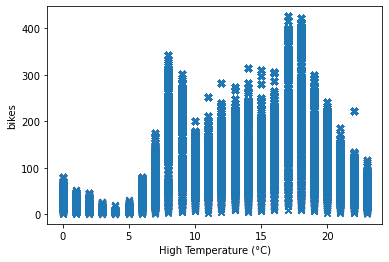

In [2]:
import matplotlib.pyplot as plt

plt.scatter(dfPhiladelphia['start_time_hourly'], dfPhiladelphia['numOfRentedBikes'], marker='x')
plt.xlabel("High Temperature (°C)")
plt.ylabel("bikes")

# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target
- We will justify the selection of features

In [19]:
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733481 entries, 0 to 733480
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   start_date          733481 non-null  object 
 1   end_date            733481 non-null  object 
 2   start_time_hourly   733481 non-null  int64  
 3   end_time_hourly     733481 non-null  int64  
 4   start_station_id    733481 non-null  int64  
 5   end_station_id      733481 non-null  int64  
 6   start_latitude      733481 non-null  float64
 7   start_longitude     733481 non-null  float64
 8   end_latitude        733481 non-null  float64
 9   end_longitude       733481 non-null  float64
 10  min_temp            733481 non-null  float64
 11  max_temp            733481 non-null  float64
 12  precip              733481 non-null  float64
 13  user_type           733481 non-null  object 
 14  dayOfWeek           733481 non-null  int64  
 15  isWeekend           733481 non-nul

The feature creation process was already done in task 1: This are all features which we created in Task 1

**Remove unnecessary features**

We won't need:
- 'end_date', because
- 'end_time_hourly', because
- 'start_station_id', because we are interested in the **total system-level demand in the next hour**
- 'end_station_id', because
- 'start_latitude', because
- 'start_longitude', because
- 'end_latitude', because
- 'end_longitude', because
- 'start_station_name', because
- 'end_station_name', because
- 'tripduration_sec', because

We will need:
- 'start_date', because
- 'start_time_hourly', because
- 'numOfRentedBikes', because

We will test/evaluate if we need the following features, in a later step (x.x.x):
- 'min_temp', because
- 'max_temp', because
- 'precip', because
- 'user_type', because
- 'dayOfWeek', because
- 'isWeekend', because
- 'season', because
- 'isHoliday', because
- 'isRushhour', because
- #'tripLengthDistance', because

In [2]:
#Take only necessary columns (implicit drop of unselected columns)
dfPhiladelphia = dfPhiladelphia[['start_date',
                                 'start_time_hourly',
                                 'min_temp',
                                 'max_temp',
                                 'isPrecip',
                                 'user_type',
                                 'start_month',
                                 'dayOfWeek',
                                 'isWeekend',
                                 'season',
                                 'isHoliday',
                                 'isRushhour',
                                 #'tripLengthDistance',
                                 'numOfRentedBikesHourly'
                                ]]

### 4.1.1 Dummy Feature Creation (maybe after evaluation)
- We already created all features we need in Task 1, but we need to change some features into dummy variables to assure predictive performance

In [21]:
# here just 2 blocks of code

### 4.1.2 Justify the selection of features / (Feature evaluation)

In [22]:
# Variance criteria or correlation criteria or filtering or embedded methods
# we will take variance & correlations

#### Variance:

In [23]:
#### take out features which will become dummys
#### season and so on missing, but we do know the variance because, we defined it
dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'precip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikes']].var()

start_time_hourly      24.980862
min_temp               87.457681
max_temp               87.615618
precip                  0.042017
dayOfWeek               3.747954
isWeekend               0.183420
isHoliday               0.020595
isRushhour              0.249996
numOfRentedBikes     7759.717475
dtype: float64

In [24]:
# min_temp & max_temp same variance => validate if they have different values

#### Correlations

In [3]:
dfPhiladelphia = dfPhiladelphia[['start_date',
                                 'start_time_hourly',
                                 'min_temp',
                                 'max_temp',
                                 'isPrecip',
                                 'user_type',
                                 'dayOfWeek',
                                 'start_month',
                                 'isWeekend',
                                 'season',
                                 'isHoliday',
                                 'isRushhour',
                                 #'tripLengthDistance',
                                 'numOfRentedBikesHourly'
                                ]]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_5524/518247390.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dfPhiladelphia.corr()


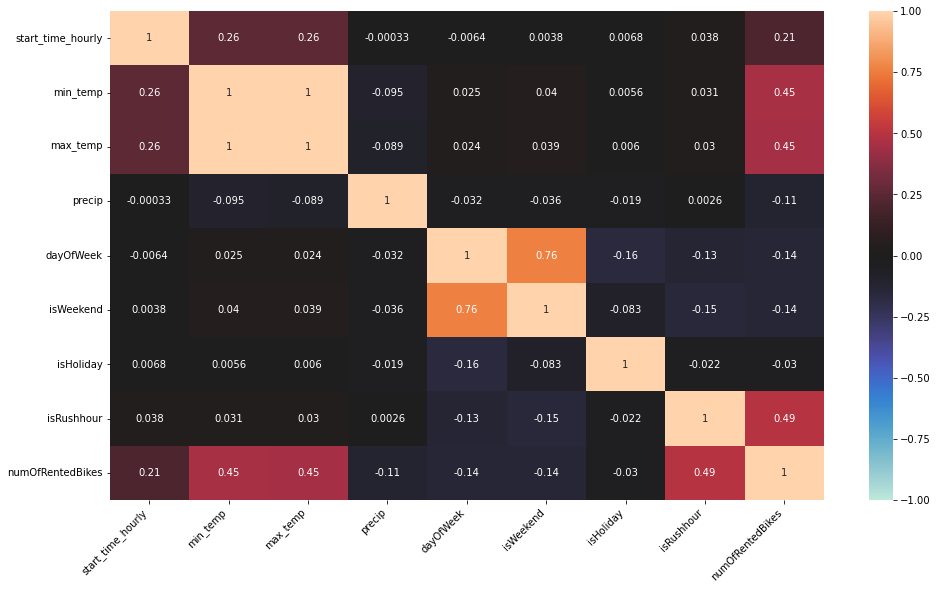

In [25]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = dfPhiladelphia.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

#### Numerical feature selection:
 
We will drop `max_temp` or `min_temp`, because they are perfectly correlated.

In addition to that we will also drop `dayOfWeek`. This is because the correlation between `dayOfWeek` and `isWeekend` as well as the correlation between `dayOfWeek` and `isHoliday` is higher than its correlation with `numOfRentedBikes`. Because the correlation of `isWeekend` and `isHoliday` is lower than the correlation of `dayOfWeek` and `isWeekend` as well as the correlation between `dayOfWeek` and `isHoliday`, we drop `dayOfWeek`.

In [ ]:
df_for_corr1 = pd.get_dummies(dfPhiladelphia['season'],prefix='is')

df_for_corr2 = pd.get_dummies(dfPhiladelphia['user_type'],prefix='is')

df_for_corr3 = pd.get_dummies(dfPhiladelphia['dayOfWeek'],prefix='is')

df_for_corr1 = df_for_corr1.join(df_for_corr2)

df_for_corr1 = df_for_corr1.join(df_for_corr3)

df_for_corr1 = df_for_corr1.join(dfPhiladelphia['numOfRentedBikesHourly'])



In [ ]:
corr = df_for_corr1.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

In [4]:
dfPhiladelphia = dfPhiladelphia[[#'start_date',
                                 'start_time_hourly',
                                 #'min_temp',
                                 'max_temp',
                                'isPrecip',
                                 'user_type',
                                 #'dayOfWeek',
                                 'isWeekend',
                                'season',
                                'start_month',
                                 'isHoliday',
                                 'isRushhour',
                                 #'tripLengthDistance',
                                 'numOfRentedBikesHourly'
                                ]]


### 4.1.3 (Visualisation of dependencies)

## 4.2 Model Building & Evaluation

**Normalize the input values**

In [10]:
#set output frame and input frame
#x = dfPhiladelphia#[[#list all selected input features#]]  

#y = dfPhiladelphia['numOfRentedBikes']

In [5]:
def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [6]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['isPrecip', 'start_time_hourly',
                                 'user_type',
                                 #'dayOfWeek',
                                 'isWeekend',
                                 'start_month',
                                 'season',
                                 'isHoliday',
                                 'isRushhour']
numeric = ['max_temp']


In [7]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAPE: {100 * metrics.mean_absolute_percentage_error(y_true, y_predicted): .3f} %")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [8]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

In [19]:
# Normalize the data

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

#x_norm = scaler.fit_transform(x)

# transform categorical variables (or splitting date in day-month-year)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [9]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphia.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphia['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val = x_train
y_train_val = y_train

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

### 4.2.1 First Regression (Decision Tree)

Using Decision Tree Regression to predict the `numOfRentedBikesHourly`.

### ggf nur in test und train

In [10]:
# creating the regression model

tree_reg = DecisionTreeRegressor(criterion="friedman_mse", random_state=42)

In [11]:
pipeline = pipeline_fit_predict(tree_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAPE:  4.314 %
MAE:  5.205
MSE:  178.257
RMSE:  13.351
R2:  97.707 %
Max Residual Error:  297.871


**Looking for the best Hyperparameters**

In [60]:
# defining the parameters of the model for grid search (the hyperparameter tuning)

model_para = {'model__max_depth': range(1,51)
             # 'model__min_impurity_decrease':
              # min_samples_leaf
              # alpha
             }

In [61]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_parameters_for_model(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=6,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

In [62]:
# creating the pipeline, particularly the model, to use it for find_best_parameters_for_model

pipeline = pipeline_for_prediction(categoric, numeric, tree_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['precip',
                                                   'start_time_hourly',
                                                   'user_type', 'isWeekend',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
                                       random_state=42))])

### score noch anders? vllt r squared: was wäre logisch?

In [63]:
# doing grid search

find_best_parameters_for_model(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__max_depth=1........................................
[CV 1/15; 1/50] END .....model__max_depth=1;, score=-5912.989 total time=   0.1s
[CV 2/15; 1/50] START model__max_depth=1........................................
[CV 2/15; 1/50] END .....model__max_depth=1;, score=-5874.775 total time=   0.1s
[CV 3/15; 1/50] START model__max_depth=1........................................
[CV 3/15; 1/50] END .....model__max_depth=1;, score=-5844.199 total time=   0.1s
[CV 4/15; 1/50] START model__max_depth=1........................................
[CV 4/15; 1/50] END .....model__max_depth=1;, score=-5850.362 total time=   0.1s
[CV 5/15; 1/50] START model__max_depth=1........................................
[CV 5/15; 1/50] END .....model__max_depth=1;, score=-5858.076 total time=   0.1s
[CV 6/15; 1/50] START model__max_depth=1.....................

[CV 6/15; 4/50] END .....model__max_depth=4;, score=-3245.091 total time=   0.2s
[CV 7/15; 4/50] START model__max_depth=4........................................
[CV 7/15; 4/50] END .....model__max_depth=4;, score=-3225.522 total time=   0.2s
[CV 8/15; 4/50] START model__max_depth=4........................................
[CV 8/15; 4/50] END .....model__max_depth=4;, score=-3240.089 total time=   0.2s
[CV 9/15; 4/50] START model__max_depth=4........................................
[CV 9/15; 4/50] END .....model__max_depth=4;, score=-3257.900 total time=   0.2s
[CV 10/15; 4/50] START model__max_depth=4.......................................
[CV 10/15; 4/50] END ....model__max_depth=4;, score=-3256.238 total time=   0.2s
[CV 11/15; 4/50] START model__max_depth=4.......................................
[CV 11/15; 4/50] END ....model__max_depth=4;, score=-3250.732 total time=   0.2s
[CV 12/15; 4/50] START model__max_depth=4.......................................
[CV 12/15; 4/50] END ....mod

[CV 12/15; 7/50] END ....model__max_depth=7;, score=-2189.401 total time=   0.3s
[CV 13/15; 7/50] START model__max_depth=7.......................................
[CV 13/15; 7/50] END ....model__max_depth=7;, score=-2143.572 total time=   0.3s
[CV 14/15; 7/50] START model__max_depth=7.......................................
[CV 14/15; 7/50] END ....model__max_depth=7;, score=-2117.953 total time=   0.3s
[CV 15/15; 7/50] START model__max_depth=7.......................................
[CV 15/15; 7/50] END ....model__max_depth=7;, score=-2144.164 total time=   0.3s
[CV 1/15; 8/50] START model__max_depth=8........................................
[CV 1/15; 8/50] END .....model__max_depth=8;, score=-1837.112 total time=   0.4s
[CV 2/15; 8/50] START model__max_depth=8........................................
[CV 2/15; 8/50] END .....model__max_depth=8;, score=-1858.960 total time=   0.4s
[CV 3/15; 8/50] START model__max_depth=8........................................
[CV 3/15; 8/50] END .....mod

[CV 3/15; 11/50] END ...model__max_depth=11;, score=-1163.594 total time=   0.7s
[CV 4/15; 11/50] START model__max_depth=11......................................
[CV 4/15; 11/50] END ...model__max_depth=11;, score=-1105.012 total time=   0.7s
[CV 5/15; 11/50] START model__max_depth=11......................................
[CV 5/15; 11/50] END ...model__max_depth=11;, score=-1129.831 total time=   0.7s
[CV 6/15; 11/50] START model__max_depth=11......................................
[CV 6/15; 11/50] END ...model__max_depth=11;, score=-1143.516 total time=   0.7s
[CV 7/15; 11/50] START model__max_depth=11......................................
[CV 7/15; 11/50] END ...model__max_depth=11;, score=-1126.526 total time=   0.7s
[CV 8/15; 11/50] START model__max_depth=11......................................
[CV 8/15; 11/50] END ...model__max_depth=11;, score=-1144.292 total time=   0.7s
[CV 9/15; 11/50] START model__max_depth=11......................................
[CV 9/15; 11/50] END ...mode

[CV 9/15; 14/50] END ....model__max_depth=14;, score=-761.858 total time=   0.9s
[CV 10/15; 14/50] START model__max_depth=14.....................................
[CV 10/15; 14/50] END ...model__max_depth=14;, score=-742.968 total time=   0.9s
[CV 11/15; 14/50] START model__max_depth=14.....................................
[CV 11/15; 14/50] END ...model__max_depth=14;, score=-753.640 total time=   1.0s
[CV 12/15; 14/50] START model__max_depth=14.....................................
[CV 12/15; 14/50] END ...model__max_depth=14;, score=-764.590 total time=   0.9s
[CV 13/15; 14/50] START model__max_depth=14.....................................
[CV 13/15; 14/50] END ...model__max_depth=14;, score=-746.316 total time=   0.9s
[CV 14/15; 14/50] START model__max_depth=14.....................................
[CV 14/15; 14/50] END ...model__max_depth=14;, score=-766.663 total time=   0.9s
[CV 15/15; 14/50] START model__max_depth=14.....................................
[CV 15/15; 14/50] END ...mod

[CV 15/15; 17/50] END ...model__max_depth=17;, score=-549.933 total time=   1.2s
[CV 1/15; 18/50] START model__max_depth=18......................................
[CV 1/15; 18/50] END ....model__max_depth=18;, score=-535.359 total time=   1.3s
[CV 2/15; 18/50] START model__max_depth=18......................................
[CV 2/15; 18/50] END ....model__max_depth=18;, score=-529.492 total time=   1.2s
[CV 3/15; 18/50] START model__max_depth=18......................................
[CV 3/15; 18/50] END ....model__max_depth=18;, score=-535.093 total time=   1.2s
[CV 4/15; 18/50] START model__max_depth=18......................................
[CV 4/15; 18/50] END ....model__max_depth=18;, score=-498.201 total time=   1.2s
[CV 5/15; 18/50] START model__max_depth=18......................................
[CV 5/15; 18/50] END ....model__max_depth=18;, score=-513.528 total time=   1.3s
[CV 6/15; 18/50] START model__max_depth=18......................................
[CV 6/15; 18/50] END ....mod

[CV 6/15; 21/50] END ....model__max_depth=21;, score=-464.615 total time=   1.4s
[CV 7/15; 21/50] START model__max_depth=21......................................
[CV 7/15; 21/50] END ....model__max_depth=21;, score=-466.445 total time=   1.4s
[CV 8/15; 21/50] START model__max_depth=21......................................
[CV 8/15; 21/50] END ....model__max_depth=21;, score=-445.783 total time=   1.4s
[CV 9/15; 21/50] START model__max_depth=21......................................
[CV 9/15; 21/50] END ....model__max_depth=21;, score=-465.050 total time=   1.4s
[CV 10/15; 21/50] START model__max_depth=21.....................................
[CV 10/15; 21/50] END ...model__max_depth=21;, score=-444.229 total time=   1.4s
[CV 11/15; 21/50] START model__max_depth=21.....................................
[CV 11/15; 21/50] END ...model__max_depth=21;, score=-456.473 total time=   1.4s
[CV 12/15; 21/50] START model__max_depth=21.....................................
[CV 12/15; 21/50] END ...mod

[CV 12/15; 24/50] END ...model__max_depth=24;, score=-429.814 total time=   1.5s
[CV 13/15; 24/50] START model__max_depth=24.....................................
[CV 13/15; 24/50] END ...model__max_depth=24;, score=-409.950 total time=   1.5s
[CV 14/15; 24/50] START model__max_depth=24.....................................
[CV 14/15; 24/50] END ...model__max_depth=24;, score=-438.439 total time=   1.4s
[CV 15/15; 24/50] START model__max_depth=24.....................................
[CV 15/15; 24/50] END ...model__max_depth=24;, score=-422.656 total time=   1.4s
[CV 1/15; 25/50] START model__max_depth=25......................................
[CV 1/15; 25/50] END ....model__max_depth=25;, score=-435.444 total time=   1.4s
[CV 2/15; 25/50] START model__max_depth=25......................................
[CV 2/15; 25/50] END ....model__max_depth=25;, score=-430.504 total time=   1.5s
[CV 3/15; 25/50] START model__max_depth=25......................................
[CV 3/15; 25/50] END ....mod

[CV 3/15; 28/50] END ....model__max_depth=28;, score=-419.593 total time=   1.6s
[CV 4/15; 28/50] START model__max_depth=28......................................
[CV 4/15; 28/50] END ....model__max_depth=28;, score=-394.525 total time=   1.6s
[CV 5/15; 28/50] START model__max_depth=28......................................
[CV 5/15; 28/50] END ....model__max_depth=28;, score=-400.317 total time=   1.6s
[CV 6/15; 28/50] START model__max_depth=28......................................
[CV 6/15; 28/50] END ....model__max_depth=28;, score=-417.320 total time=   1.5s
[CV 7/15; 28/50] START model__max_depth=28......................................
[CV 7/15; 28/50] END ....model__max_depth=28;, score=-415.746 total time=   1.5s
[CV 8/15; 28/50] START model__max_depth=28......................................
[CV 8/15; 28/50] END ....model__max_depth=28;, score=-402.134 total time=   1.5s
[CV 9/15; 28/50] START model__max_depth=28......................................
[CV 9/15; 28/50] END ....mod

[CV 9/15; 31/50] END ....model__max_depth=31;, score=-414.997 total time=   1.5s
[CV 10/15; 31/50] START model__max_depth=31.....................................
[CV 10/15; 31/50] END ...model__max_depth=31;, score=-398.885 total time=   1.5s
[CV 11/15; 31/50] START model__max_depth=31.....................................
[CV 11/15; 31/50] END ...model__max_depth=31;, score=-409.530 total time=   1.5s
[CV 12/15; 31/50] START model__max_depth=31.....................................
[CV 12/15; 31/50] END ...model__max_depth=31;, score=-408.558 total time=   1.5s
[CV 13/15; 31/50] START model__max_depth=31.....................................
[CV 13/15; 31/50] END ...model__max_depth=31;, score=-391.556 total time=   1.5s
[CV 14/15; 31/50] START model__max_depth=31.....................................
[CV 14/15; 31/50] END ...model__max_depth=31;, score=-418.282 total time=   1.5s
[CV 15/15; 31/50] START model__max_depth=31.....................................
[CV 15/15; 31/50] END ...mod

[CV 15/15; 34/50] END ...model__max_depth=34;, score=-400.210 total time=   1.5s
[CV 1/15; 35/50] START model__max_depth=35......................................
[CV 1/15; 35/50] END ....model__max_depth=35;, score=-416.631 total time=   1.5s
[CV 2/15; 35/50] START model__max_depth=35......................................
[CV 2/15; 35/50] END ....model__max_depth=35;, score=-413.290 total time=   1.5s
[CV 3/15; 35/50] START model__max_depth=35......................................
[CV 3/15; 35/50] END ....model__max_depth=35;, score=-410.810 total time=   1.5s
[CV 4/15; 35/50] START model__max_depth=35......................................
[CV 4/15; 35/50] END ....model__max_depth=35;, score=-388.085 total time=   1.5s
[CV 5/15; 35/50] START model__max_depth=35......................................
[CV 5/15; 35/50] END ....model__max_depth=35;, score=-392.516 total time=   1.5s
[CV 6/15; 35/50] START model__max_depth=35......................................
[CV 6/15; 35/50] END ....mod

[CV 6/15; 38/50] END ....model__max_depth=38;, score=-408.791 total time=   1.5s
[CV 7/15; 38/50] START model__max_depth=38......................................
[CV 7/15; 38/50] END ....model__max_depth=38;, score=-407.229 total time=   1.5s
[CV 8/15; 38/50] START model__max_depth=38......................................
[CV 8/15; 38/50] END ....model__max_depth=38;, score=-393.442 total time=   1.5s
[CV 9/15; 38/50] START model__max_depth=38......................................
[CV 9/15; 38/50] END ....model__max_depth=38;, score=-413.209 total time=   1.5s
[CV 10/15; 38/50] START model__max_depth=38.....................................
[CV 10/15; 38/50] END ...model__max_depth=38;, score=-398.335 total time=   1.5s
[CV 11/15; 38/50] START model__max_depth=38.....................................
[CV 11/15; 38/50] END ...model__max_depth=38;, score=-406.767 total time=   1.5s
[CV 12/15; 38/50] START model__max_depth=38.....................................
[CV 12/15; 38/50] END ...mod

[CV 12/15; 41/50] END ...model__max_depth=41;, score=-407.339 total time=   1.5s
[CV 13/15; 41/50] START model__max_depth=41.....................................
[CV 13/15; 41/50] END ...model__max_depth=41;, score=-388.503 total time=   1.5s
[CV 14/15; 41/50] START model__max_depth=41.....................................
[CV 14/15; 41/50] END ...model__max_depth=41;, score=-416.193 total time=   1.5s
[CV 15/15; 41/50] START model__max_depth=41.....................................
[CV 15/15; 41/50] END ...model__max_depth=41;, score=-400.188 total time=   1.5s
[CV 1/15; 42/50] START model__max_depth=42......................................
[CV 1/15; 42/50] END ....model__max_depth=42;, score=-416.806 total time=   1.6s
[CV 2/15; 42/50] START model__max_depth=42......................................
[CV 2/15; 42/50] END ....model__max_depth=42;, score=-413.270 total time=   1.6s
[CV 3/15; 42/50] START model__max_depth=42......................................
[CV 3/15; 42/50] END ....mod

[CV 3/15; 45/50] END ....model__max_depth=45;, score=-410.732 total time=   1.6s
[CV 4/15; 45/50] START model__max_depth=45......................................
[CV 4/15; 45/50] END ....model__max_depth=45;, score=-388.094 total time=   1.6s
[CV 5/15; 45/50] START model__max_depth=45......................................
[CV 5/15; 45/50] END ....model__max_depth=45;, score=-392.582 total time=   1.6s
[CV 6/15; 45/50] START model__max_depth=45......................................
[CV 6/15; 45/50] END ....model__max_depth=45;, score=-408.791 total time=   1.5s
[CV 7/15; 45/50] START model__max_depth=45......................................
[CV 7/15; 45/50] END ....model__max_depth=45;, score=-407.256 total time=   1.5s
[CV 8/15; 45/50] START model__max_depth=45......................................
[CV 8/15; 45/50] END ....model__max_depth=45;, score=-393.442 total time=   1.5s
[CV 9/15; 45/50] START model__max_depth=45......................................
[CV 9/15; 45/50] END ....mod

[CV 9/15; 48/50] END ....model__max_depth=48;, score=-413.209 total time=   1.6s
[CV 10/15; 48/50] START model__max_depth=48.....................................
[CV 10/15; 48/50] END ...model__max_depth=48;, score=-398.335 total time=   1.5s
[CV 11/15; 48/50] START model__max_depth=48.....................................
[CV 11/15; 48/50] END ...model__max_depth=48;, score=-406.767 total time=   1.6s
[CV 12/15; 48/50] START model__max_depth=48.....................................
[CV 12/15; 48/50] END ...model__max_depth=48;, score=-407.339 total time=   1.6s
[CV 13/15; 48/50] START model__max_depth=48.....................................
[CV 13/15; 48/50] END ...model__max_depth=48;, score=-388.503 total time=   1.5s
[CV 14/15; 48/50] START model__max_depth=48.....................................
[CV 14/15; 48/50] END ...model__max_depth=48;, score=-416.193 total time=   1.5s
[CV 15/15; 48/50] START model__max_depth=48.....................................
[CV 15/15; 48/50] END ...mod

**Training the model with the best hyperparameters**

In [ ]:
# train the model with the above chosen hyperparameters

#tree_reg = DecisionTreeRegressor(criterion="friedman_mse", random_state=42) ADDING THE FEATURES WITH CORRECT VALUE

#pipeline = pipeline_fit_predict(tree_reg, categoric, numeric, x_val, y_val, x_test, y_test)

In [ ]:
# plot decision tree

### 4.2.2 Second Regression (Maybe lasso/Random Forest)

### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**Building the model with the functional API of Keras:**

In [ ]:
#pip install tensorflow

In [ ]:
# Import keras libraries
import tensorflow
from tensorflow inport keras
from keras import layers

In [ ]:
###### INTEGRATE HYPERPARAMTERTUNING TIPPS!
###### RELU IN EACH LAYER?

def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(8,)) # shapesize dependent of input features
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') # MAYBE TRY DIFFERENT OPTIMIZER
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [ ]:
#pip install keras-tuner

In [ ]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hyperparametertuning:

- We choose the HyperBand Tuner from Keras

In [ ]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    #directory = os.path.normpath('C:/#######')
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [ ]:
tuner.search_space_summary()

To clear the training outputs after each training step define a callback:

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [ ]:
tuner.results_summary()

Get optimal hyperparameters:

In [ ]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")

Get the best model:

In [ ]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show a summary of the model:

In [ ]:
model_ann.summary()

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz`and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [ ]:
#pip install pydot

In [ ]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

In hyperparameter tuning the model was only trained with 20 epochs because of the performance. So now we continue the training to get a optimal result.

Define a callback which stops earlier when their is no further improvement and which avoids overfitting:

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50, 
    restore_best_weights=True 
    )

In [ ]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

**Evaluation of the performance of the model:**

In [ ]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphia["numOfRentedBikes"].mean()))*100,2), "%")